In [1]:
from irbasis_util.four_point_ph_view import *
from irbasis_util.internal import *
from irbasis_util.regression import *
from irbasis_util.tensor_regression import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#padding on the y axis between label and axis
plt.rcParams['ytick.major.pad']='10'

dpi_out = 400
fig_width = 3.39
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches
MAX_HEIGHT_INCHES = 8.0
if fig_height > MAX_HEIGHT_INCHES:
    print("WARNING: fig_height too large:" + fig_height + 
          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    fig_height = MAX_HEIGHT_INCHES
#fig, ax = plt.subplots(figsize = (fig_width, fig_height), frameon=True)
small_tick_size = 8
small_label_size = 8

In [3]:
# Implementation of Rohringer et al. () 2012)
def _delta(i, j):
    if i==j:
        return 1
    else:
        return 0

def _F_ph(U, beta, n, np, m):
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    r1 = nu + omega
    r2 = nu_p + omega
    tmp = 1. / (nu * r1 * r2 * nu_p)
    Fuu = (-0.25 * beta * (U**2) * (_delta(n,np) - _delta(m,0)) *
               (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    t1 = 0.125 * (U**3) * (nu**2 + r1**2 + r2**2 + nu_p**2) * tmp
    t2 = (3.0 / 16.0) * (U**5) * tmp
    t3 = (beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(0.5 * beta * U)))
              * (2 * _delta(nu, -nu_p - m) + _delta(m, 0)) *
              (1 + 0.25 * (U / r1)**2) * (1 + 0.25 * (U / r2)**2))
    t4 = (-beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(-0.5 * beta * U)))
              * (2 * _delta(nu, nu_p) + _delta(m, 0)) *
              (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    Fud = -U + t1 + t2 + t3 + t4
    return Fuu, Fud

def _G2_conn_ph(U, beta, n, np, m):
    Fuu, Fud = _F_ph(U, beta, n, np, m)
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    hU = 0.5 * U
    leggs_1 = nu * (nu + omega) * nu_p * (nu_p + omega)
    leggs_2 = ((hU**2 + nu**2) * (hU**2 + nu_p**2) *
                   (hU**2 + (nu + omega)**2) * (hU**2 + (nu_p + omega)**2))
    leggs = leggs_1 / leggs_2
    return (leggs * Fuu + leggs * Fud)

In [4]:
boson_freq = 10
Lambda = 1000.0
beta = 50.0
U = 2.0
wmax = Lambda / beta
alpha = 0.0

# 1% error
noise = 1e-4

In [5]:
#alpha = 1e-15
augmented = True
phb = FourPointPHView(boson_freq, Lambda, beta, 1e-5, augmented)
Nl = phb.Nl
whichl = Nl - 1
print("Nl", Nl)
# build the sampling frequency structure
sp = phb.sampling_points_matsubara(whichl)
#print(S.shape)
n_sp = len(sp)

Nl 30


In [6]:
def elbow_method(Ds, squared_errors):
    """
    
    Parameters
    ----------
    Ds    regularization parameters in ascending order
    squared_errors  corresponding squared_errors

    Returns index of optimal value of alpha in alphas
    -------

    """
    x = numpy.log(Ds)
    y = numpy.log(squared_errors)
    
    a = (y[-1] - y[0])/(x[-1] - x[0])
    y -= a * (x - x[0]) + y[0]
    
    r = numpy.argmin(y)
    if isinstance(r, numpy.int64):
        return r
    else:
        return r[0]

# Regression with multiple values of alpha
def kruskal_complex_Ds(tensors_A, y, alpha, Ds, decomposed_S):
    """
    
    Parameters
    ----------
    A
    y

    Returns
    -------
    
     Nw, Nr, freq_dim, linear_dim, tensors_A, y, alpha, D):

    """
    coeffs_D = []
    squared_errors_D = []
    Nw, Nr, linear_dim = tensors_A[0].shape
    print(Nw, Nr, linear_dim)
    for i, D in enumerate(Ds):
        #print(tensors_A)
        #print(y)
        print("D ", D)
        precond = None
        model = OvercompleteGFModel(Nw, Nr, 2, linear_dim, tensors_A, y, alpha, D)
        info = optimize_als(model, 1000, tol_rmse = 1e-4, solver='svd', optimize_alpha=1e-5, verbose = 1)
        coeffs = model.full_tensor_x()
        coeffs_D.append(coeffs)
        e = model.mse()
        print("D = ", D, e, " num_ite", len(info['losss']))
        squared_errors_D.append(e)
    
    squared_errors_D = numpy.array(squared_errors_D)
        
    # Choose optimal alpha using Elbow method 
    opt_idx = elbow_method(Ds, squared_errors_D)
    
    return coeffs_D, squared_errors_D, opt_idx

In [7]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
# S: [(3, 2, 2, Nl), (3, 2, 2, Nl)]
# prj = S * prj
def construct_prj(sp):
    n_sp = len(sp)
    prj = phb.projector_to_matsubara_vec(sp, decomposed_form=True)
    S = phb.normalized_S(decomposed_form=True)
    for i in range(2):
        prj[i] *= S[i][None, :, :, :, :]
        prj[i] = prj[i].reshape((n_sp, 12, Nl))
    return prj
prj = construct_prj(sp)
S_decomposed = phb.normalized_S(decomposed_form=True)

# Build the check frequency structure
n1n2_check = []
niw = 100
niw_hf = 10000
wide_niw_check = numpy.hstack((range(-niw_hf, -niw, 500), range(-niw, niw, 10), range(niw, niw_hf, 500)))
for i, j in product(wide_niw_check, repeat=2):
    n1n2_check.append((i, j))
prj_check = construct_prj(n1n2_check)

numpy.random.seed(200)
Giwn = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in sp])
print ("adding noise")
noise_iwn = numpy.random.normal(loc=0.0, scale=noise, size=(len(sp))) * numpy.amax(numpy.abs(Giwn))
print("noise size=", noise * numpy.amax(numpy.abs(Giwn)))
Giwn = noise_iwn + Giwn
#print(Giwn.imag)

adding noise
noise size= 0.0074997933707400015


In [8]:
#numpy.seterr(all='raise')
Ds = [2, 4, 6, 8, 10]
%time coeffs_D, se_D, opt_D_idx = kruskal_complex_Ds(prj, Giwn, alpha, Ds, S_decomposed)

7804 12 30
D  2
epoch =  0  loss =  0.8799908041465669  rmse =  0.9380782505455322  alpha =  0.0
norm of x  0 8.553917290610418
norm of x  1 8455.497364419654
norm of x  2 8664.317549268357
epoch =  20  loss =  0.005859545960269403  rmse =  0.07660097674414176  alpha =  7.812998142627645e-11
norm of x  0 18.188436413236122
norm of x  1 220.13957891394662
norm of x  2 2468.0922260652133
epoch =  40  loss =  0.0008685941293468839  rmse =  0.029470923649261502  alpha =  7.022672343557248e-12
norm of x  0 23.391569676883687
norm of x  1 61.8950408828351
norm of x  2 3100.69334955127
epoch =  60  loss =  0.0007774862195682392  rmse =  0.027883300137371073  alpha =  7.018607075689833e-12
norm of x  0 22.87662917386532
norm of x  1 73.88698678706913
norm of x  2 2943.4463176992263
epoch =  80  loss =  0.0006940200721253927  rmse =  0.02634411483861662  alpha =  6.3792651778121045e-12
norm of x  0 22.67529292366539
norm of x  1 81.08923818627076
norm of x  2 2922.1017145926826
epoch =  100  lo

epoch =  100  loss =  5.6786972669535154e-05  rmse =  0.0075356829171606705  alpha =  3.76119192361671e-12
norm of x  0 10.524870762259203
norm of x  1 792.076331777985
norm of x  2 737.2599395307324
epoch =  120  loss =  5.556794561187714e-05  rmse =  0.007454356212899641  alpha =  4.012514384044159e-12
norm of x  0 10.404461080132393
norm of x  1 757.3089131965435
norm of x  2 711.7947253721206
D =  10 5.556742654879548e-05  num_ite 121
CPU times: user 38min 46s, sys: 5min 10s, total: 43min 56s
Wall time: 22min 36s


In [9]:
print(se_D)

[5.31687909e-04 8.12414994e-05 5.74914519e-05 5.51518797e-05
 5.55674265e-05]


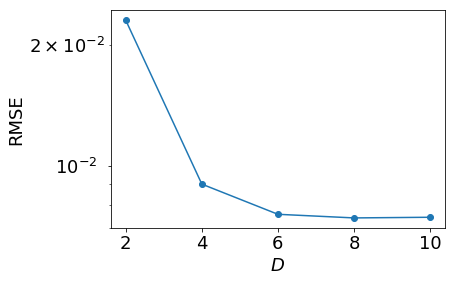

In [10]:
plt.plot(Ds, numpy.sqrt(se_D), marker='o')
plt.xlabel(r'$D$')
plt.ylabel('RMSE')
#plt.xscale('log')
plt.yscale('log')
#plt.legend(loc='best')

In [11]:
#opt_D_idx = 0
opt_D_idx = -1
D_best = Ds[opt_D_idx]
print("best value of D", D_best)

coeffs = coeffs_D[opt_D_idx].reshape((3, 2, 2, Nl, Nl))
#print(coeffs.shape)
S_2d = S_decomposed[0][:,:,:,:,None] * S_decomposed[1][:,:,:,None,:]
coeffs_gl = (S_2d * coeffs)
print(numpy.abs(coeffs_gl[0,0,0,  0:2,0:2]))
print(numpy.abs(coeffs_gl[0,0,0,  -2:,-2:]))

best value of D 10
[[0.47121566 0.22990453]
 [0.39168186 0.18560362]]
[[3.65173293e-06 1.10768067e-06]
 [2.08826666e-06 9.30476191e-07]]


In [12]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
def compute_Giwn(prj, coeff):
    niw = prj[0].shape[0]
    #print(prj[0].shape)
    prj_mat = numpy.einsum('nrl,nrm->nrlm', prj[0], prj[1]).reshape((niw, 3 * 2 * 2 * Nl * Nl))
    return prj_mat@coeffs.reshape((3 * 2 * 2 * Nl * Nl))

Giwn_check = compute_Giwn(prj_check, coeffs)
print(Giwn_check.shape)
Giwn_check_ref = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in n1n2_check])

diff = numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref))
print(diff)
print(diff < 1e-3)

(3600,)
0.020539496783482776
False


[-0.01088182  0.01433175  0.00533894 ...  0.00672272  0.00608989
  0.01190283]


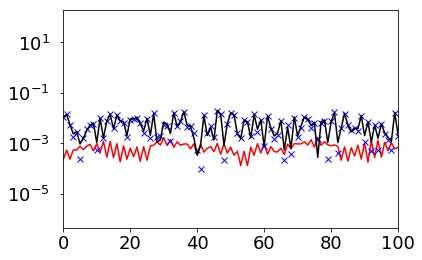

In [13]:
Giwn_reconst = compute_Giwn(prj, coeffs)
#plt.plot(Giwn_reconst.real, c='r')
#plt.plot(Giwn.real)
plt.plot(numpy.abs(Giwn_reconst), c='r')
plt.plot(numpy.abs(Giwn), c='b', ls='', marker='x')
plt.plot(numpy.abs(Giwn-Giwn_reconst), c='k', ls='-', marker='')
plt.yscale("log")
plt.xlim([0,100])
print(Giwn.real)

[-0.01088182  0.01433175  0.00533894 ...  0.00672272  0.00608989
  0.01190283]


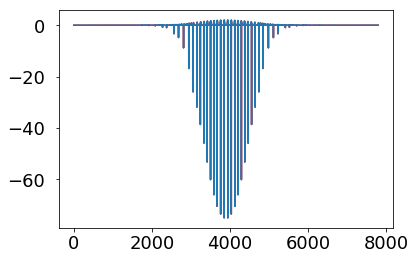

In [14]:
Giwn_reconst = compute_Giwn(prj, coeffs)
plt.plot(Giwn_reconst.real, c='r')
plt.plot(Giwn.real)
print(Giwn.real)

74.99793370740001


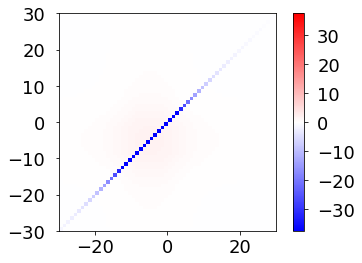

In [15]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

N = 100
N_zoom = 30
#x = numpy.linspace(-N, N, 2*N+1)
x = numpy.arange(-N, N+1)
G2_conn_ph = numpy.zeros((2 * N + 1,2 * N + 1), dtype=float)

for i in range(2 * N + 1):
    for j in range(2 * N + 1):
        n = x[i]
        np = x[j]
        G2_conn_ph[i, j] = _G2_conn_ph(U, beta, n, np, boson_freq)

vrange = numpy.amax(numpy.abs(G2_conn_ph))
plt.imshow(G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()
print (vrange)

#plt.legend(loc='best',shadow=True,frameon=False)

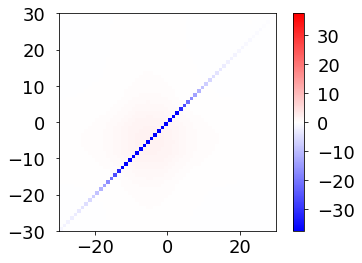

In [16]:
n1n2_check_2d = numpy.array([(x[i], x[j]) for i in range(2 * N + 1) for j in range(2 * N + 1)])
prj_check_2d = construct_prj(n1n2_check_2d)

Giwn_check = compute_Giwn(prj_check_2d, coeffs)
Giwn_check = Giwn_check.reshape((2 * N + 1, 2 * N + 1))
vrange = numpy.amax(numpy.abs(Giwn_check))
plt.imshow(Giwn_check.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()

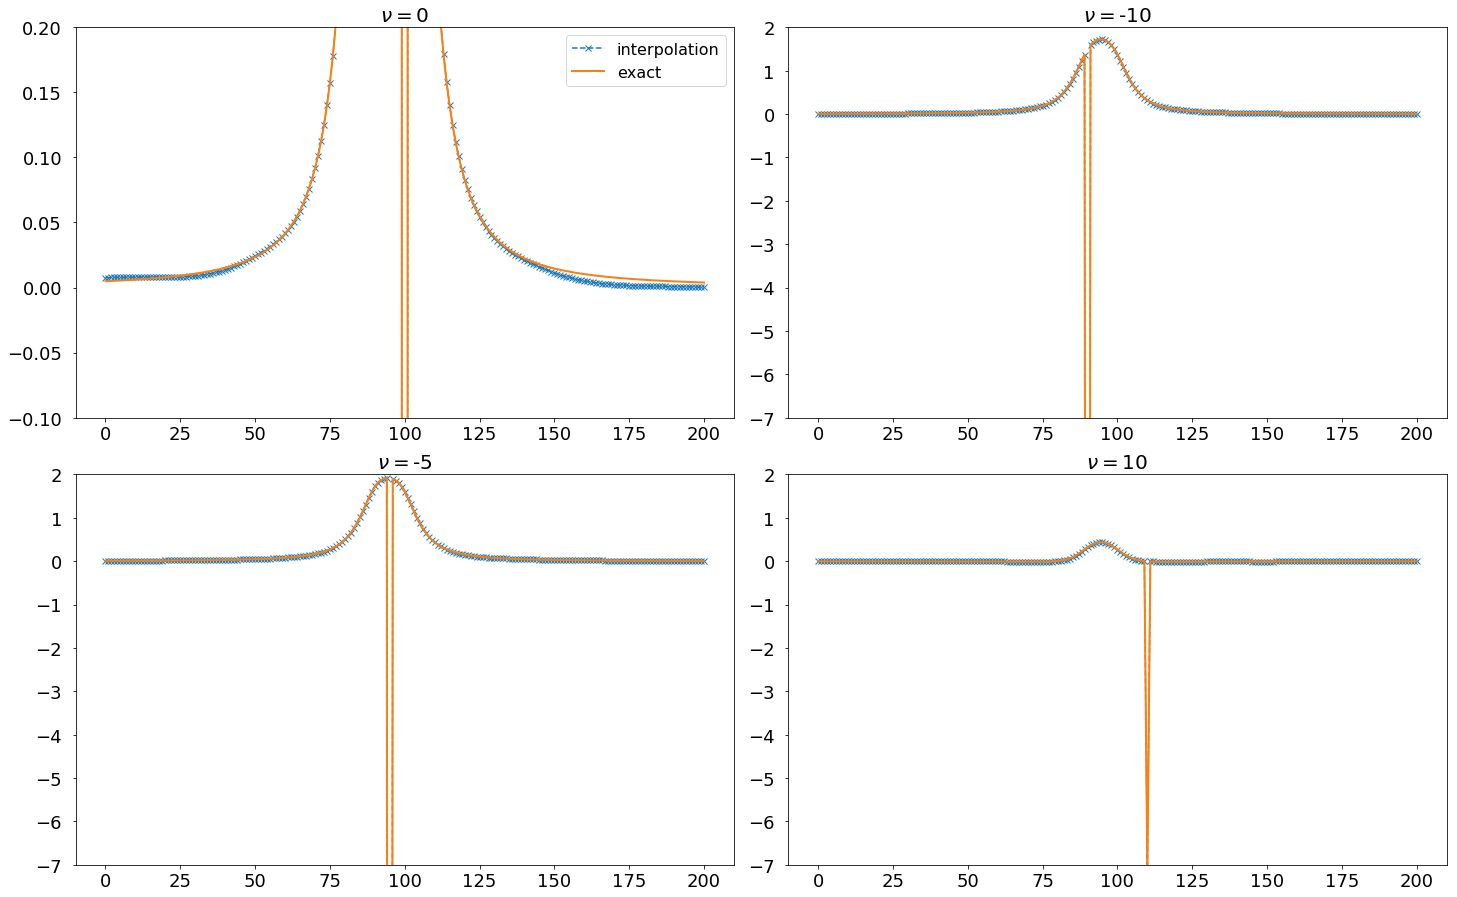

In [17]:
title_size = 20
vert_range = 1.
scale_factor = 1

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-0.1, 0.2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_wide.pdf")

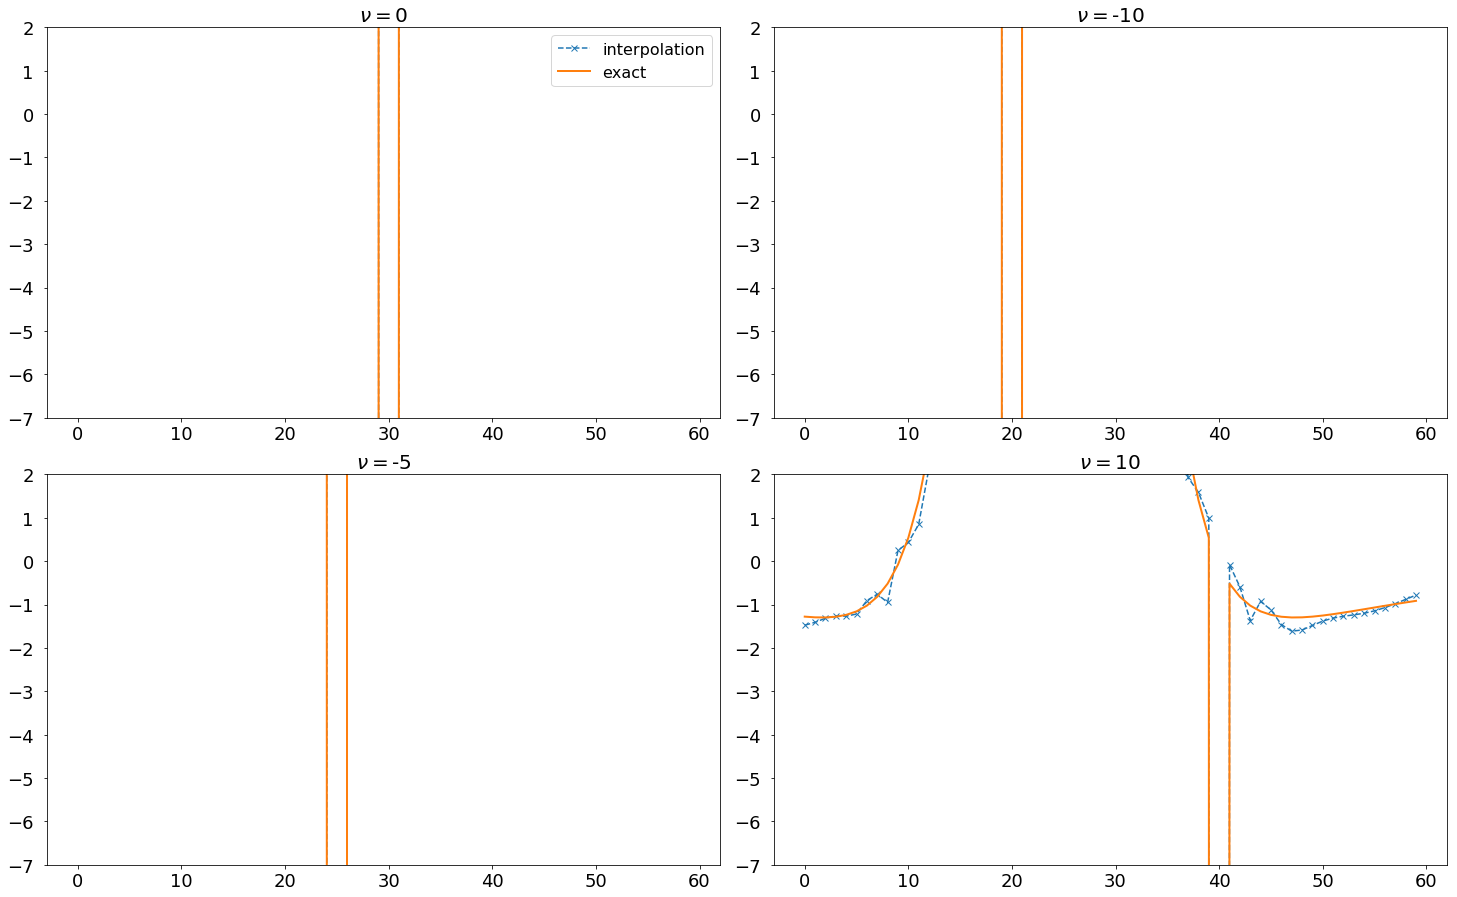

In [18]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_zoom.pdf")